# Design optimalisation

example different than, but based on: http://mumfordbrainstats.tumblr.com/post/131150941751/efficiency-day3-matlab-example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from __future__ import division
import pprint

%matplotlib inline

## Haemodynamic Response Function definition

We first define the function of the HRF as it is defined in SPM and FSL.

In [2]:
def spm_hrf(TR,p=[6,16,1,1,6,0,32]):
    p=[float(x) for x in p]

    fMRI_T = 16.0

    TR=float(TR)
    dt  = TR/fMRI_T
    u   = np.arange(p[6]/dt + 1) - p[5]/dt
    hrf=scipy.stats.gamma.pdf(u,p[0]/p[2],scale=1.0/(dt/p[2])) - scipy.stats.gamma.pdf(u,p[1]/p[3],scale=1.0/(dt/p[3]))/p[4]
    good_pts=np.array(range(np.int(p[6]/TR)))*fMRI_T
    good_pts_ls = [int(x) for x in good_pts]
    hrf=hrf[good_pts_ls]
    hrf = hrf/np.sum(hrf);
    return hrf

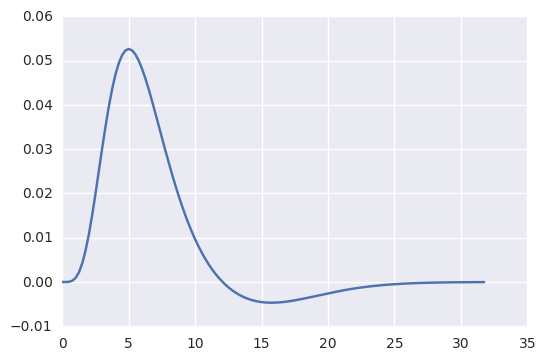

In [3]:
resolution = 0.25
hrf25 = spm_hrf(resolution)

xaxis = np.arange(0,len(hrf25)/4,0.25) #making sure x-axis displays seconds

plt.plot(xaxis,hrf25)

## Design 1: fixed order + fixed ITI

We will now generate a design matrix for an experiment with 2 different stimulus types (eg. faces and houses) with 100 trials.  The intertrial interval (ITI) is 4 seconds:

    | stim |     ITI    | stim |     ITI    | stim |     ITI    | stim |     ITI    | stim |     ITI    |
    |--2s--|-----4s-----|--2s--|-----4s-----|--2s--|-----4s-----|--2s--|-----4s-----|--2s--|-----4s-----|

We will first specify all design parameters and the onsets in seconds.

In [4]:
ntrials = 100

TR_s = 2
stimDur_s = 2
ITI_s = 4
totalDur_s = int((stimDur_s+ITI_s) * ntrials)

onsets = np.arange(0,totalDur_s,(ITI_s+stimDur_s))
print("onsets:\n"+str(onsets))
order = np.array([0,1]*int(ntrials/2))
print("order:\n"+str(order))

X0_onsets_s = onsets[order==0]
X1_onsets_s = onsets[order==1]

print("- stimulus 0 onsets:\n"+ str(X0_onsets_s))
print("- stimulus 1 onsets:\n"+ str(X1_onsets_s))

onsets:
[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594]
order:
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
- stimulus 0 onsets:
[  0  12  24  36  48  60  72  84  96 108 120 132 144 156 168 180 192 204
 216 228 240 252 264 276 288 300 312 324 336 348 360 372 384 396 408 420
 432 444 456 468 480 492 504 516 528 540 552 564 576 588]
- stimulus 1 onsets:
[  6  18  30  42  54  66  78  90 102 114 126 138 150 162 174 186 198 210
 222 234 246 258 270 282 294 306 318 330 342 354 366 37

We will move now to resolution units.  As such, all variables will be interpretable in terms of the number of timepoints in our design matrix.

In [5]:
TR = int(TR_s/resolution)
totalDur = int(totalDur_s/resolution)
stimDur = int(stimDur_s/resolution)

X0_onsets = [int(x/resolution) for x in X0_onsets_s]
X1_onsets = [int(x/resolution) for x in X1_onsets_s]

print("- stimulus onsets:\n"+ str(X0_onsets))
print("- response onsets:\n"+ str(X1_onsets))

- stimulus onsets:
[0, 48, 96, 144, 192, 240, 288, 336, 384, 432, 480, 528, 576, 624, 672, 720, 768, 816, 864, 912, 960, 1008, 1056, 1104, 1152, 1200, 1248, 1296, 1344, 1392, 1440, 1488, 1536, 1584, 1632, 1680, 1728, 1776, 1824, 1872, 1920, 1968, 2016, 2064, 2112, 2160, 2208, 2256, 2304, 2352]
- response onsets:
[24, 72, 120, 168, 216, 264, 312, 360, 408, 456, 504, 552, 600, 648, 696, 744, 792, 840, 888, 936, 984, 1032, 1080, 1128, 1176, 1224, 1272, 1320, 1368, 1416, 1464, 1512, 1560, 1608, 1656, 1704, 1752, 1800, 1848, 1896, 1944, 1992, 2040, 2088, 2136, 2184, 2232, 2280, 2328, 2376]


#### Design matrix of stimulus 1

We will now make a design matrix for the stimuli:
1. Generate empty design matrix X (of length totalDur - in resolution units)
2. At the stimulus onsets: 1
3. Stimulus durations are 2 seconds, or 8 timepoints: we set the 7 timepoints following onsets also to 1
4. Convolve with the HRF to get the 'expected signal'
5. Downsample to TR, to capture **measured** timepoints

(-0.1, 0.5)

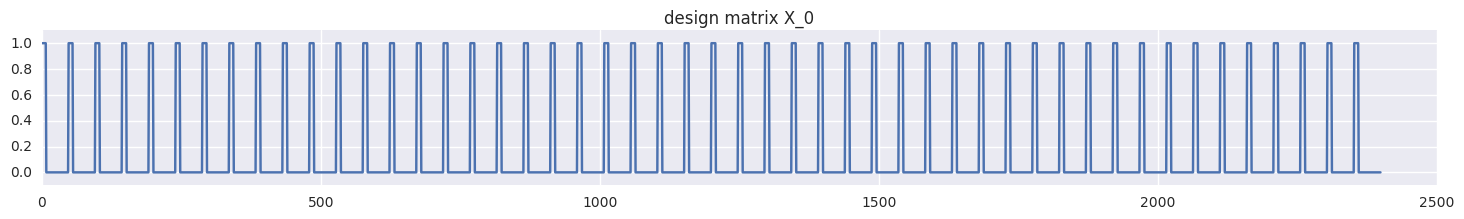

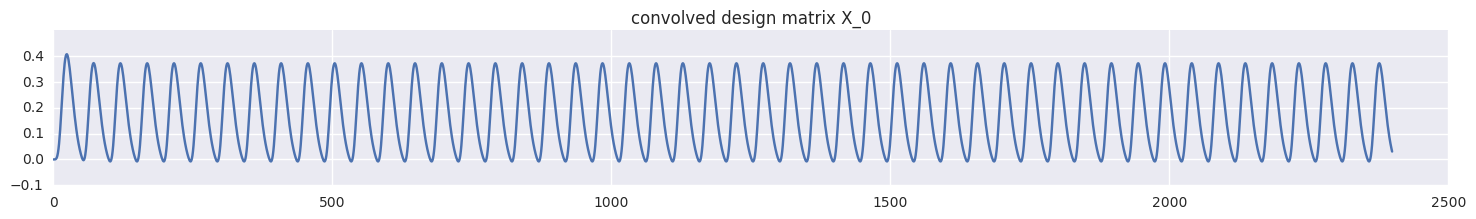

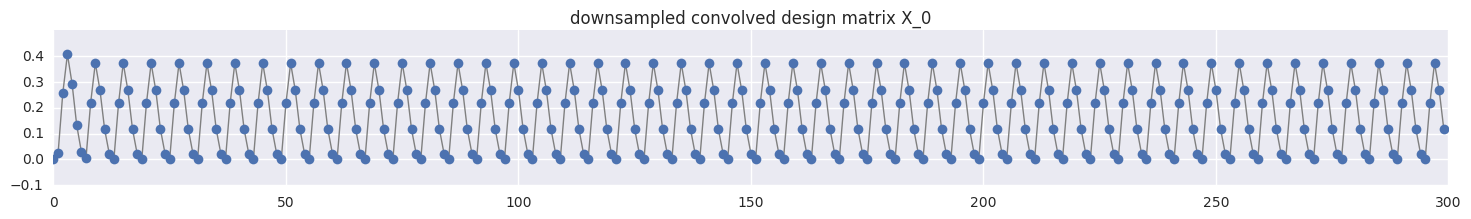

In [6]:
# 1
X0 = np.zeros(int(totalDur))

# 2
X0[X0_onsets] = 1

# 3
for shift in np.arange(1,int(stimDur)):
    ind = [x+shift for x in X0_onsets]
    X0[ind] = 1 

# 4
X0Z_highres = np.convolve(X0,hrf25)[:len(X0)]

#5
TRid = np.arange(0,totalDur,TR)
X0Z = X0Z_highres[TRid]

#plots
plt.figure(figsize=(18,2))
plt.plot(X0)
plt.title("design matrix X_0")
plt.ylim([-0.1,1.1])

plt.figure(figsize=(18,2))
plt.plot(X0Z_highres)
plt.title("convolved design matrix X_0")
plt.ylim([-0.1,0.5])

plt.figure(figsize=(18,2))
plt.title("downsampled convolved design matrix X_0")
plt.plot(X0Z.T,color="grey",lw=1)
plt.plot(X0Z.T,marker='o',lw=0)
plt.ylim([-0.1,0.5])

The design matrix is now constructed, but in resolution units.  What we measure is only a subset of this: we will now downsample to TR units.

#### Design matrix of stimulus 2

In [7]:
X1 = np.zeros(int(totalDur))
X1[X1_onsets] = 1
for shift in np.arange(1,int(stimDur)):
    ind = [x+shift for x in X1_onsets]
    X1[ind] = 1 
X1Z_highres = np.convolve(X1,hrf25)[:len(X1)]
TRid = np.arange(0,totalDur,TR)
X1Z = X1Z_highres[TRid]

#### Put together in design matrix X

<span style="color:limegreen`">**Q: Why is the signal for the two first stimuli higher than the rest?**</span>

(-0.1, 0.5)

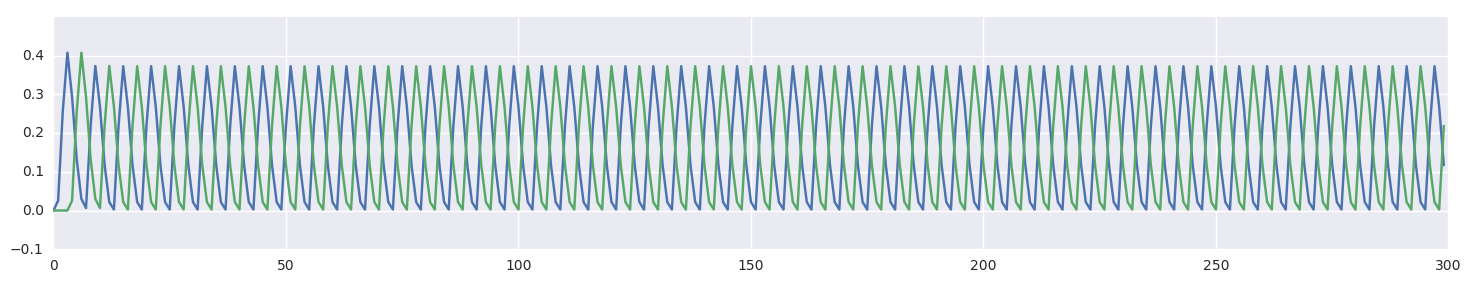

In [8]:
XZ = np.array([X0Z,X1Z])
plt.figure(figsize=(18,3))
plt.plot(XZ.T)
plt.ylim([-0.1,0.5])

#### Demean regressors

<span style="color:limegreen`">**Why demean the regressors?**</span>

In [9]:
# mean centering
means = XZ.dot(np.ones(XZ.shape[1]).T)/XZ.shape[1]
means_expand = np.outer(means,np.ones(XZ.shape[1]))
XZ_demeaned = XZ-means_expand

### Design 1: efficiency

$\text{Eff} = n \ / \ \text{Trace}(C(X'X)^{-1}C')$

In [10]:
XtX = XZ_demeaned.dot(XZ_demeaned.T)
XtXi = np.linalg.inv(XtX)

Contrast 1: stimulus 1 vs. baseline

In [11]:
C = np.matrix([1,0])
eff1 = float(1/(C*np.matrix(XtXi)*C.T))
print(eff1)

0.9311823683290757


Contrast 2: stimulus 1 vs. stimulus 2

In [12]:
C = np.matrix([1,-1])
eff2 = float(1/(C*np.matrix(XtXi)*C.T))
print(eff2)

5.069348068051347


Contrast 1: stimulus 1 vs. baseline & stimulus 2 vs. baseline

In [13]:
C = np.matrix([[0,1],[1,0]])
eff3 = C.shape[1]/np.trace(C*np.matrix(XtXi)*C.T)
print(eff3)

0.933550621059


Save results

In [14]:
Results = {}
Results['design_1']={
    'contrastX0':eff1,
    'contrastX0vsX1':eff2,
    'contrastX0X1':eff3
}

Matrices = {}
Matrices['design_1'] = XZ_demeaned

pprint.pprint(Results)

{'design_1': {'contrastX0': 0.9311823683290757,
              'contrastX0X1': 0.93355062105907638,
              'contrastX0vsX1': 5.069348068051347}}


## Design 2: fixed order + variable ITI

We will now generate a design matrix for the same experiment with 100 trials.  We will now sample the ITI from a uniform distribution (3-5s):

    | stim |    ITI     | stim |    ITI     | stim |    ITI     | stim |    ITI     | stim |    ITI     |
    |--2s--|----3-5s----|--2s--|----3-5s----|--2s--|----3-5s----|--2s--|----3-5s----|--2s--|----3-5s----|

We will immediately sample in resolution units (otherwise there are only 3 possible values for ITI: [3,4,5] )

In [15]:
success = False
while success == False:
    # sample ITI's from uniform distribution
    ITI = np.random.uniform(3,5,ntrials-1)+stimDur_s
    onsets = np.append([0],np.cumsum(ITI))
    # round onsets to seconds
    onsets_s = np.floor(onsets/resolution)*resolution
    # from onsets in seconds to timepoints
    onsets = onsets_s/resolution

    # due to the random proces, it could be that the total design is longer than you'd want
    # if this happens: draw a new sample of ITI's
    if np.max(onsets_s)<totalDur_s:
        success = True

print("onsets: "+str(onsets_s))

onsets: [   0.      5.25   11.25   17.25   22.5    28.     34.75   40.75   46.
   52.5    58.75   64.5    70.25   76.5    82.75   89.     94.75   99.75
  106.75  113.75  120.25  125.5   131.5   138.25  143.25  148.5   155.
  161.5   168.25  174.25  181.25  188.    194.25  201.    207.25  214.
  219.5   225.75  231.    236.5   242.75  248.5   254.    259.5   266.
  273.    279.5   285.25  291.75  297.5   302.5   308.5   315.    320.
  326.5   332.75  337.75  344.25  351.    357.25  362.75  369.5   374.75
  380.5   386.5   393.    399.    404.5   409.5   415.    420.25  425.75
  432.25  437.75  443.    448.75  455.5   461.5   468.    473.5   478.5
  484.5   490.75  497.    503.75  509.25  515.    520.5   526.25  532.75
  538.5   543.75  550.    556.75  563.    568.75  575.5   580.75  586.5
  592.5 ]


/home/vagrant/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


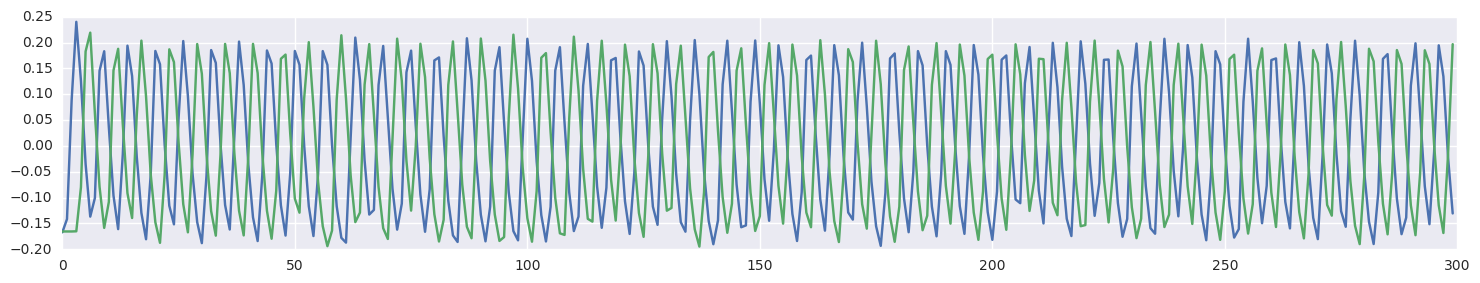

In [16]:
X = np.zeros([2,int(totalDur)])
XZ_highres = np.zeros([2,int(totalDur)])

for stim in range(2):
    ind = [int(x) for x in onsets[order==stim]]
    X[stim,ind] = 1
    for shift in np.arange(1,int(stimDur)):
        ind = [x+shift for x in onsets[order==stim]]
        X[stim,ind] = 1
    XZ_highres[stim,:] = np.convolve(X[stim,:],hrf25)[:X.shape[1]]
    
#downsample
TRid = np.arange(0,totalDur,TR)
XZ = XZ_highres[:,TRid]

#demean
means = XZ.dot(np.ones(XZ.shape[1]).T)/XZ.shape[1]
means_expand = np.outer(means,np.ones(XZ.shape[1]))
XZ_demeaned = XZ-means_expand

plt.figure(figsize=(18,3))
plt.plot(XZ_demeaned.T)


In [17]:
XtX = XZ_demeaned.dot(XZ_demeaned.T)
XtXi = np.linalg.inv(XtX)
C = np.matrix([1,0])
eff1 = float(1/(C*np.matrix(XtXi)*C.T))
C = np.matrix([1,-1])
eff2 = float(1/(C*np.matrix(XtXi)*C.T))
C = np.matrix([[0,1],[1,0]])
eff3 = C.shape[1]/np.trace(C*np.matrix(XtXi)*C.T)
Results['design_2']={
    'contrastX0':eff1,
    'contrastX0vsX1':eff2,
    'contrastX0X1':eff3
}

Matrices['design_2'] = XZ_demeaned

pprint.pprint(Results)

{'design_1': {'contrastX0': 0.9311823683290757,
              'contrastX0X1': 0.93355062105907638,
              'contrastX0vsX1': 5.069348068051347},
 'design_2': {'contrastX0': 1.3484563900417792,
              'contrastX0X1': 1.3566645907054042,
              'contrastX0vsX1': 5.001750842457085}}


## Design 3: variable order + variable ITI

We will now generate a design matrix for the same experiment with 100 trials.  We will take the ITI's from before, but randomize the order.

    | stim |    ITI     | stim |    ITI     | stim |    ITI     | stim |    ITI     | stim |    ITI     |
    |--2s--|----3-5s----|--2s--|----3-5s----|--2s--|----3-5s----|--2s--|----3-5s----|--2s--|----3-5s----|



In [18]:
order = np.random.binomial(1,0.5,100)
print("random order of stimuli: \n"+str(order))

random order of stimuli: 
[1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1
 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1
 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0]


/home/vagrant/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


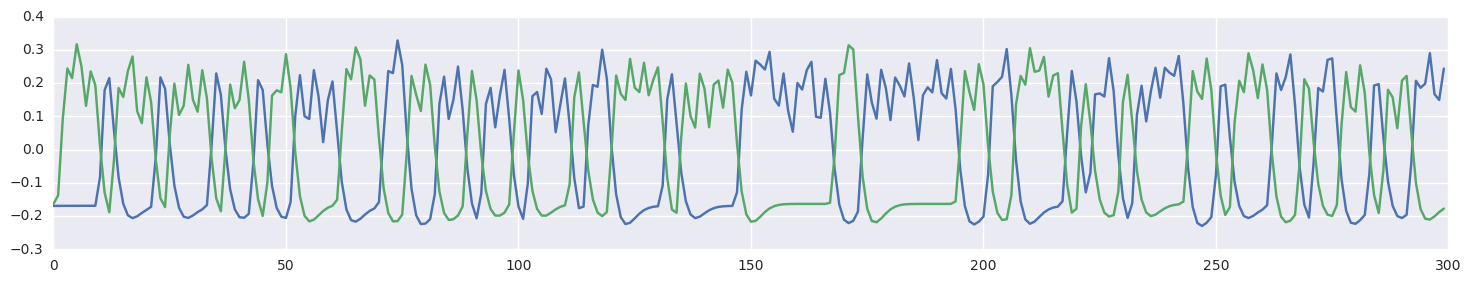

In [19]:
X = np.zeros([2,int(totalDur)])
XZ_highres = np.zeros([2,int(totalDur)])

for stim in range(2):
    ind = [int(x) for x in onsets[order==stim]]
    X[stim,ind] = 1
    for shift in np.arange(1,int(stimDur)):
        ind = [x+shift for x in onsets[order==stim]]
        X[stim,ind] = 1
    XZ_highres[stim,:] = np.convolve(X[stim,:],hrf25)[:X.shape[1]]
    
#downsample
TRid = np.arange(0,totalDur,TR)
XZ = XZ_highres[:,TRid]

#demean
means = XZ.dot(np.ones(XZ.shape[1]).T)/XZ.shape[1]
means_expand = np.outer(means,np.ones(XZ.shape[1]))
XZ_demeaned = XZ-means_expand

plt.figure(figsize=(18,3))
plt.plot(XZ_demeaned.T)


In [20]:
XtX = XZ_demeaned.dot(XZ_demeaned.T)
XtXi = np.linalg.inv(XtX)
C = np.matrix([1,0])
eff1 = float(1/(C*np.matrix(XtXi)*C.T))
C = np.matrix([1,-1])
eff2 = float(1/(C*np.matrix(XtXi)*C.T))
C = np.matrix([[0,1],[1,0]])
eff3 = C.shape[1]/np.trace(C*np.matrix(XtXi)*C.T)
Results['design_3']={
    'contrastX0':eff1,
    'contrastX0vsX1':eff2,
    'contrastX0X1':eff3
}

Matrices['design_3'] = XZ_demeaned

pprint.pprint(Results)

{'design_1': {'contrastX0': 0.9311823683290757,
              'contrastX0X1': 0.93355062105907638,
              'contrastX0vsX1': 5.069348068051347},
 'design_2': {'contrastX0': 1.3484563900417792,
              'contrastX0X1': 1.3566645907054042,
              'contrastX0vsX1': 5.001750842457085},
 'design_3': {'contrastX0': 1.4101969209398852,
              'contrastX0X1': 1.3987984340677095,
              'contrastX0vsX1': 9.065224223949576}}


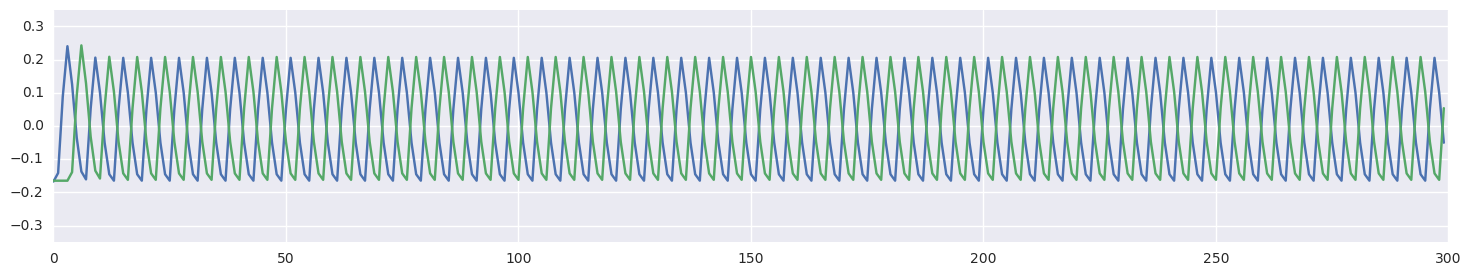

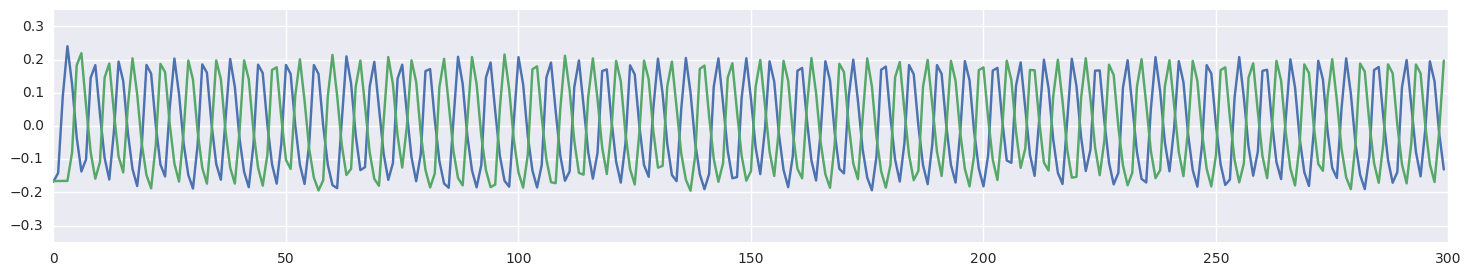

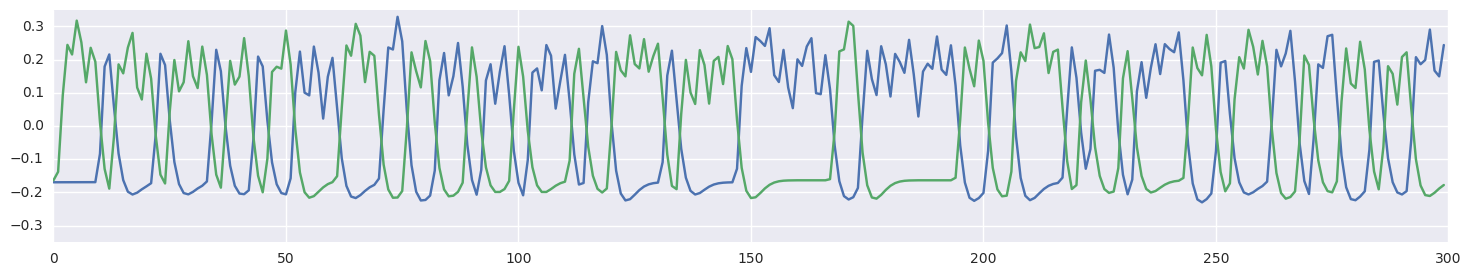

In [21]:
for des in ["design_1","design_2","design_3"]:
    plt.figure(figsize=(18,3))
    plt.plot(Matrices[des].T)
    plt.ylim([-0.35,0.35])

In [22]:
eff = []
best = 0
worst = 100

for sim in range(50000):

    order = np.random.binomial(1,0.5,100)
    if sim == 0:
        order = np.array([0]*int(ntrials/2)+[1]*int(ntrials/2))

    X = np.zeros([2,int(totalDur)])
    XZ_highres = np.zeros([2,int(totalDur)])

    for stim in range(2):
        ind = [int(x) for x in onsets[order==stim]]
        X[stim,ind] = 1
        for shift in np.arange(1,int(stimDur)):
            ind = [x+shift for x in onsets[order==stim]]
            X[stim,ind] = 1
        XZ_highres[stim,:] = np.convolve(X[stim,:],hrf25)[:X.shape[1]]

    #downsample
    TRid = np.arange(0,totalDur,TR)
    XZ = XZ_highres[:,TRid]

    #demean
    means = XZ.dot(np.ones(XZ.shape[1]).T)/XZ.shape[1]
    means_expand = np.outer(means,np.ones(XZ.shape[1]))
    XZ_demeaned = XZ-means_expand

    #compute efficiency
    XtX = XZ_demeaned.dot(XZ_demeaned.T)
    XtXi = np.linalg.inv(XtX)
    C = np.matrix([[1,-1]])
    efficiency = 1/np.trace(C*np.matrix(XtXi)*C.T)
    if sim == 0:
        blocked = XZ_demeaned
        blocked_eff = efficiency
    eff.append(efficiency)
    
    if efficiency > best:
        bestdes = XZ_demeaned
        best = efficiency
    if efficiency < worst:
        worstdes = XZ_demeaned
        worst = efficiency


/home/vagrant/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


/home/vagrant/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


8.67329304077
9.56588675082


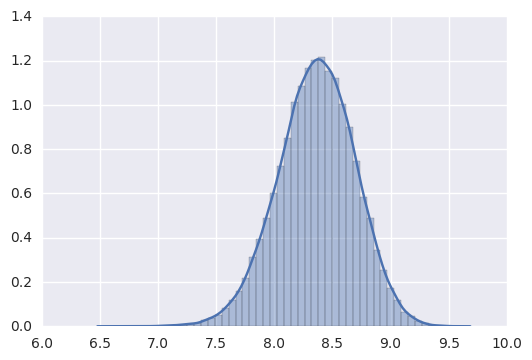

In [23]:
sns.distplot(eff)
print(blocked_eff)
print(np.max(eff))

(-0.35, 0.35)

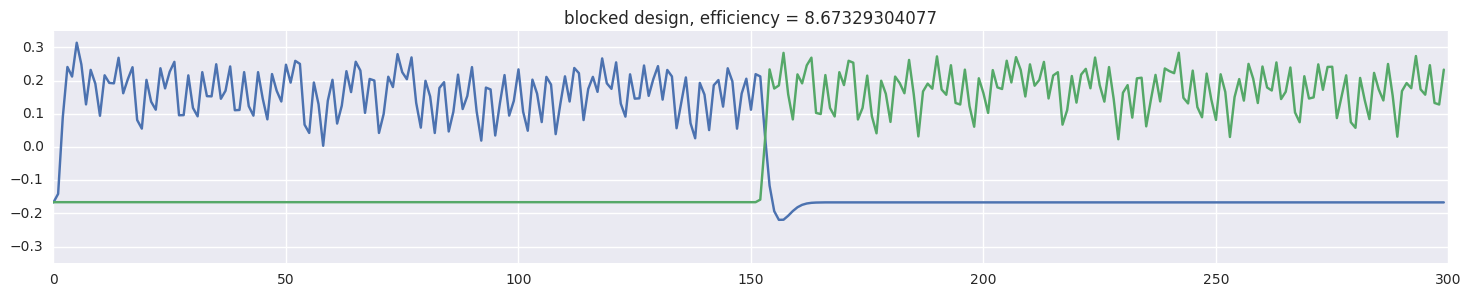

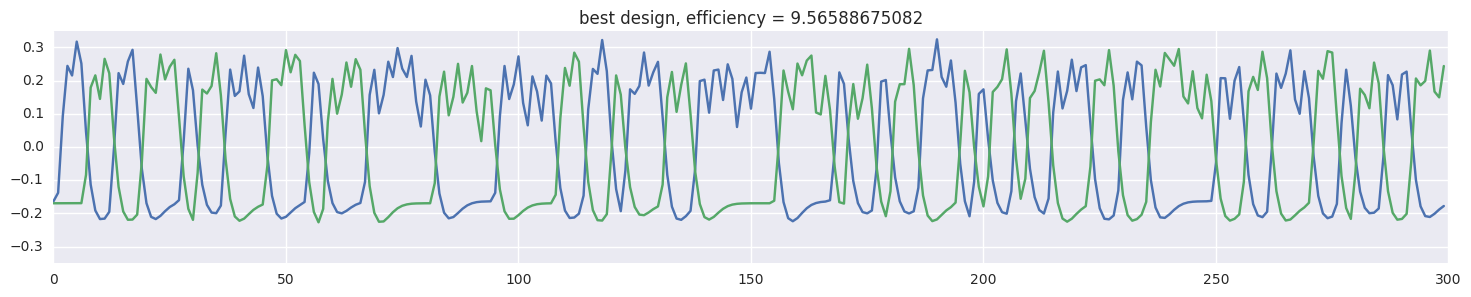

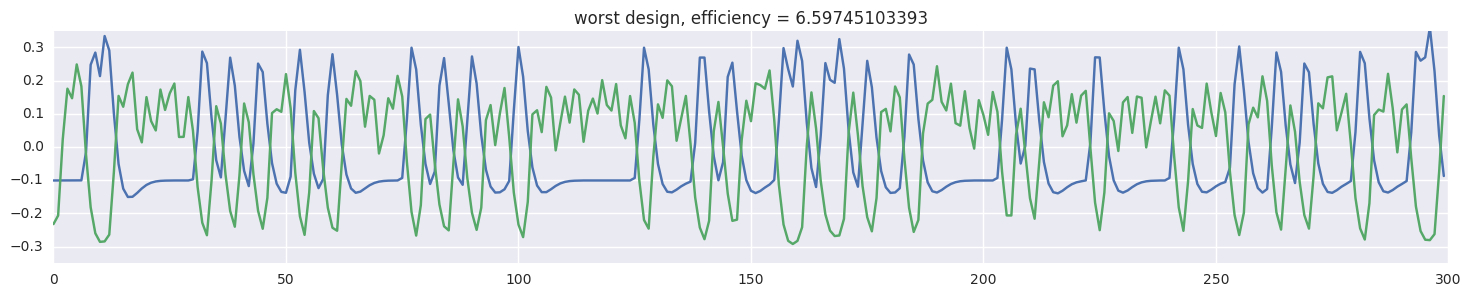

In [24]:
plt.figure(figsize=(18,3))
plt.plot(blocked.T)
plt.title("blocked design, efficiency = "+str(blocked_eff))
plt.ylim([-0.35,0.35])

plt.figure(figsize=(18,3))
plt.plot(bestdes.T)
plt.title("best design, efficiency = "+str(best))
plt.ylim([-0.35,0.35])

plt.figure(figsize=(18,3))
plt.plot(worstdes.T)
plt.title("worst design, efficiency = "+str(worst))
plt.ylim([-0.35,0.35])